**`데이터 요약`**

- 2013년 9월부터 유럽인이 사용한 신용카드 거래 데이터셋
- 거래 데이터는 사기 또는 정상 레이블을 가지고 있으며, 새로운 거래 데이터에 맞는 레이블을 예측하기 위해 머신러닝을 활용한 사기 탐지 솔루션 구축을 목표로함.
- 매우 불균형한 형태이며 284,807건 거래 중 492건만 사기(0.172%)임
- 28개의 feature가 있고, 모두 숫자이며 범주형 변수는 없음
- 해당 feature들은 원본 feature가 아니라 주성분 분석의 결과임


In [1]:
"""메인 라이브러리"""
import numpy as np
import pandas as pd
import os

"""시각화 관련 라이브러리"""
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

"""데이터 준비 관련 라이브러리"""
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

"""알고리즘 관련 라이브러리"""
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

### 1. 데이터 읽기

In [2]:
current_path = os.getcwd()
file = os.path.sep.join(["", "datasets", "credit_card_data", "credit_card.csv"])
data=pd.read_csv(current_path+file)
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. 데이터 탐색하기

##### 1) 요약 통계량 생성

In [3]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
print("Number of fraudulent transactions : ", data['Class'].sum())

Number of fraudulent transactions :  492


> 사기 거래는 총 492건이고, 인스턴스 284,807건과 컬럼 31개가 있습니다. 
거래 시간의 데이터 범위는 0-172,792 사이이고, 거래 금액은 0-2,567,116 사이입니다.

##### 2) feature별로 숫자가 아닌 값 식별하기

In [6]:
nanCounter = np.isnan(data).sum()
nanCounter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

##### 3) feature별로 고유값 식별하기

In [7]:
distinctCounter = data.apply(lambda x: len(x.unique()))
distinctCounter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

> 거래시간 feature의 고유값이 124,592건이나 관측치는 284,807건으로 일부 거래 시간 값이 여러 거래에 걸쳐 중복됐다는 말입니다. 

### 3. feature 행렬 및 레이블 배열 생성하기

##### 1) feature 행렬 x 및 레이블 배열 y 생성

In [8]:
datax = data.copy().drop(['Class'], axis=1)
datay = data['Class'].copy()

##### 2) feature 행렬 x 표준화하기

In [9]:
featuresToScale = datax.drop(['Time'], axis=1).columns
sx = pp.StandardScaler(copy=True)
datax.loc[:, featuresToScale] = sx.fit_transform(datax[featuresToScale])

datax.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


### 4. feature 엔지니어링 및 feature 선택하기

> 예제 데이터로 사용하는 신용카드 사기 데이터셋은 이미 PCA에서 파생된 주요 성분만 남아있기 때문에 불필요한 데이터 중복은 제거됐습니다. 
feature간 상관관계를 보면 서로 연관성이 매우 낮은 것을 알 수 있습니다. 

In [10]:
corrlationMatrix = pd.DataFrame(data=[], index=datax.columns, columns=datax.columns)
for i in datax.columns:
    for j in datax.columns:
        corrlationMatrix.loc[i, j] = np.round(pearsonr(datax.loc[:,i], datax.loc[:,j])[0], 2)
        
corrlationMatrix

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Time,1,0.12,-0.01,-0.42,-0.11,0.17,-0.06,0.08,-0.04,-0.01,...,-0.05,0.04,0.14,0.05,-0.02,-0.23,-0.04,-0.01,-0.01,-0.01
V1,0.12,1,-0,-0,0,0,0,-0,0,0,...,0,0,0,0,-0,-0,-0,0,-0,-0.23
V2,-0.01,-0,1,0,-0,-0,0,0,-0,0,...,-0,0,0,0,0,0,0,-0,-0,-0.53
V3,-0.42,-0,0,1,0,-0,0,0,0,0,...,0,-0,-0,-0,0,0,-0,0,0,-0.21
V4,-0.11,0,-0,0,1,-0,-0,0,-0,0,...,-0,0,0,0,0,0,-0,0,0,0.1
V5,0.17,0,-0,-0,-0,1,0,0,0,-0,...,-0,-0,0,0,-0,0,0,0,-0,-0.39
V6,-0.06,0,0,0,-0,0,1,-0,-0,-0,...,0,0,-0,0,-0,0,-0,-0,0,0.22
V7,0.08,-0,0,0,0,0,-0,1,-0,-0,...,-0,0,-0,-0,0,0,-0,-0,0,0.4
V8,-0.04,0,-0,0,-0,0,-0,-0,1,0,...,-0,-0,0,0,-0,0,0,0,-0,-0.1
V9,-0.01,0,0,0,0,-0,-0,-0,0,1,...,-0,0,0,0,-0,-0,-0,0,0,-0.04


### 5. 데이터 시각화하기

> 데이터셋이 얼마나 불균형한지 알아보기 위해서 데이터를 시각화합니다.

Text(0, 0.5, 'Frequency Percentage')

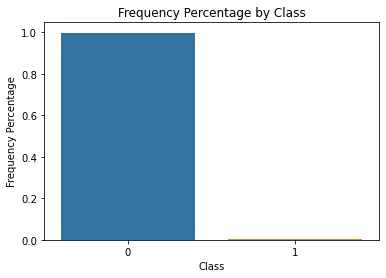

In [11]:
count_classes = pd.value_counts(data['Class'], sort=True).sort_index()
ax = sns.barplot(x = count_classes.index, y=tuple(count_classes/len(data)))
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

### 6. 모델 준비하기

##### 1) 훈련 및 테스트 데이터셋 분할하기

> 훈련 및 테스트 데이터셋 모두 사기 비율을 유지하기 위해 층화매개변수를 설정합니다. 

In [12]:
x_train, x_test, y_train, y_test = train_test_split(datax, datay, test_size=0.33, random_state=2018, stratify=datay)

##### 2) 비용 함수 선택하기

- 머신러닝 알고리즘은 훈련 예제로 학습해 비용 함수를 최소화하려고 합니다. 
- 이 예제는 클래스를 두 개 가진 지도 학습 기반의 분류 문제이므로 실제 레이블과 모델 기반 예측 레이블 사이의 교차-엔트로피를 계산하는 '이진 분류 로그 손실 함수'를 사용합니다. 

##### 3) k-겹 교차검증 데이터셋 생성하기

- 테스트셋에서 성능을 평가할 수 있도록 기존의 훈련 데이터셋을 다시 훈련 데이터셋과 검증 데이터셋으로 분할하는 것이 가장 좋습니다. 
- k번 교차 검증한 스코어를 저장하고 매번 교차검증 예측 정보를 저장하여 전체 데이터셋에 대한 교차검증 예측정보를 생성합니다. 이것은 테스트셋의 성능에 대해 최선의 전체 추정치가 될 것입니다. 

In [13]:
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 2018)

### 7. 머신러닝 모델(1)

##### 1) 로지스틱 회귀분석

In [14]:
# 하이퍼파라미터 설정하기
penalty='l2'
C=1.0
class_weight='balanced'
random_state=2018
solver='liblinear'

logReg = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, random_state=random_state, solver=solver)

- 패널티를 'l1' 대신 'l2'로 설정합니다. 'l2'가 'l1'에 비해 이상치에 덜 민감하며 거의 모든 feature에 0이 아닌 가중치를 할당해 안정적인 솔루션을 제공합니다.
- C는 정규화 강도로 정규화가 강할수록 알고리즘 복잡서을 더욱 단순하게 합니다. C는 양의 소수점 숫자여야하고 값이 작을수록 정규화가 강해집니다. 
- class_weight는 데이터에 불균형 클래스 문제가 있다는 것을 알고리즘에게 알려줌으로써 훈련시 포지티브 레이블(사기)에 무게를 더 많이 둡니다. 

##### 2) 모델 훈련시키기

In [20]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index = y_train.index, columns=[0, 1])

model = logReg
for train_index, cv_index in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_cv_fold = x_train.iloc[train_index, :], x_train.iloc[cv_index, :]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(x_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(x_train_fold)[:, 1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[x_cv_fold.index, :] = model.predict_proba(x_cv_fold)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[x_cv_fold.index, 1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss : ', loglossTraining)
    print('CV Log Loss : ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])    
print('Logistic Regression Log Loss : ', loglossLogisticRegression)

Training Log Loss :  0.10966438741861279
CV Log Loss :  0.10878924555589668
Training Log Loss :  0.10455221490580353
CV Log Loss :  0.10403007828655472
Training Log Loss :  0.11541490924057748
CV Log Loss :  0.11766027329908255
Training Log Loss :  0.11558161640976186
CV Log Loss :  0.11816761615432436
Training Log Loss :  0.09704570137521862
CV Log Loss :  0.09692400241308086
Logistic Regression Log Loss :  0.10911424314178785


##### 3) 로지스틱 회귀 모델 평가하기

Text(0.5, 1.0, 'Precision-Recall curve : Average Precision = 0.73')

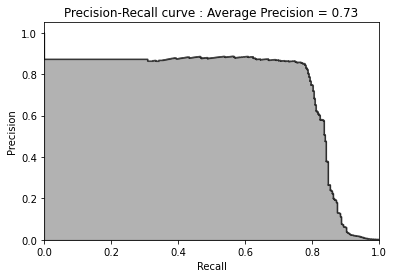

In [24]:
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel', 'prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['prediction'])

average_precision = average_precision_score(preds['trueLabel'], preds['prediction'])

plt.step(recall, precision, color='k', alpha = 0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha = 0.3, color = 'k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve : Average Precision = {0:0.2f}'.format(average_precision))

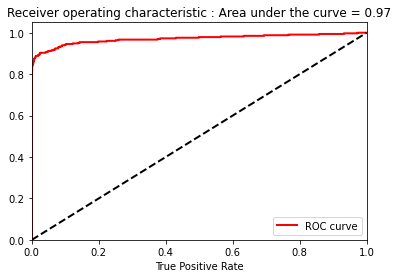

In [26]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['prediction'])

areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'r', lw=2, label = 'ROC curve')
plt.plot([0,1], [0, 1], color='k', lw=2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic : Area under the curve = {0:0.2f}'.format(areaUnderROC))

plt.legend(loc = 'lower right')
plt.show()

### 8. 머신러닝 모델(2)

#### 1) 랜덤포레스트

In [30]:
# 하이퍼파라미터 설정하기
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs=-1
random_state = 2018
class_weight='balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, 
                             max_features=max_features, 
                             max_depth=max_depth,
                             min_samples_split = min_samples_split, 
                             min_samples_leaf=min_samples_leaf,
                             min_weight_fraction_leaf=min_weight_fraction_leaf, 
                             max_leaf_nodes = max_leaf_nodes,
                             bootstrap=bootstrap,
                             oob_score=oob_score,
                             n_jobs = n_jobs,
                             random_state = random_state,
                             class_weight = class_weight)

##### 2) 모델 훈련시키

In [31]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[], index = y_train.index, columns=[0, 1])

model = RFC
for train_index, cv_index in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_cv_fold = x_train.iloc[train_index, :], x_train.iloc[cv_index, :]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(x_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(x_train_fold)[:, 1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[x_cv_fold.index, :] = model.predict_proba(x_cv_fold)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[x_cv_fold.index, 1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss : ', loglossTraining)
    print('CV Log Loss : ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])    
print('Random Forests Log Loss : ', loglossRandomForestsClassifier)

Training Log Loss :  0.0004570758747246713
CV Log Loss :  0.009090797476425144
Training Log Loss :  0.0004101805310493279
CV Log Loss :  0.012640234648018377
Training Log Loss :  0.00040027341363592047
CV Log Loss :  0.009990776910341356
Training Log Loss :  0.0003894650263288808
CV Log Loss :  0.006620007375395402
Training Log Loss :  0.0004291016183715201
CV Log Loss :  0.01348243171548044
Random Forests Log Loss :  0.010364849625132141


> 랜덤 포레스트 모델은 훈련 데이터에는 다소 과대 적합하지만 검증 데이터에 대한 로그 손실이 이전 모델인 로지스틱 회귀 모델 대비 약 1/10 수준으로 성능이 크게 개선됐습니다. 

##### 3) 모델 결과 평가하기

Text(0.5, 1.0, 'Precision-Recall curve : Average Precision = 0.79')

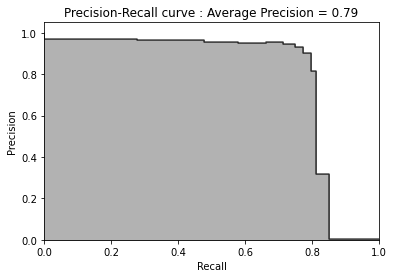

In [32]:
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel', 'prediction']
predictionsBasedOnKFoldsRandomForestsClassifier = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['prediction'])

average_precision = average_precision_score(preds['trueLabel'], preds['prediction'])

plt.step(recall, precision, color='k', alpha = 0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha = 0.3, color = 'k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve : Average Precision = {0:0.2f}'.format(average_precision))

> 이 모델은 약 80%의 정밀도로 전체 실제 사기 거래의 약 80%를 탐지할 수 있습니다.

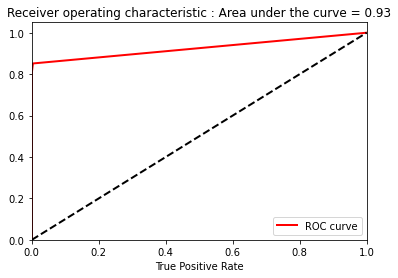

In [33]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['prediction'])

areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'r', lw=2, label = 'ROC curve')
plt.plot([0,1], [0, 1], color='k', lw=2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic : Area under the curve = {0:0.2f}'.format(areaUnderROC))

plt.legend(loc = 'lower right')
plt.show()

> 랜덤포레스트의 평균 정밀도는 0.79로 로지스틱 회귀 모델의 평균 정밀도인 0.73에 비해 분명히 개선된 수치이나 ROC 면적은 조금 나빠졌습니다.

### 9. 머신러닝 모델(3)

##### 1) XGBoost

In [47]:
# 하이퍼파라미터 설정하기
params_xGB = {
    'nthread':16, # 코어 수
    'learning rate': 0.3, # 학습률 : 범위 (0 ~ 1) , 디폴트 0.3
    'gamma': 0, # 감마 : 범위 (0 ~ 무한대) , 디폴트 0
        # 이 값이 높으면 복잡성이 감소(편향 증가, 변동 감소) 
    'max_depth': 6, # max_depth : 범위 (1 ~ 무한대) , 디폴트 6 ## 트리의 최대 깊이
    'min_child_weight': 1, # min_child_weight : 범위 (0 ~ 무한대) , 디폴트 1 ## 자식노드에 필요한 가중치의 최소 합계
    'max_delta_step': 0, # max_delta_step : 범위 (0 ~ 무한대) ,  디폴트 0 ## 각 트리의 가중치 추정을 위한 최대 델타 단계
    'subsample': 1.0, # subsample : 범위 (0 ~ 1) , 디폴트 1
        # 훈련 데이터의 샘플링 비율
    'colsample_bytree': 1.0, # colsample_bytree : 범위 (0 ~ 1) , 디폴트 1
        # 훈련 피쳐의 샘플링 비율
    'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'seed':2018,
    'silent':1
}

##### 2) 모델 훈련시키기

> 5번의 교차검증 실행 각각에 대해 그레디언트 부스팅 모델은 최대 2천 라운드로 훈련되며 교차검증 로그 손실이 감소하는지를 평가합니다. 
교차검증 로그 손실이 더 이상 개선되지 않으면 과대 적합을 피하기 위해 훈련이 중단됩니다. 

In [49]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                    index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)),
                                          y_train.ravel()):
    x_train_fold, x_cv_fold = x_train.iloc[train_index,:], \
        x_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    dtrain = xgb.DMatrix(data=x_train_fold, label=y_train_fold)
    dCV = xgb.DMatrix(data=x_cv_fold)
    
    bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, 
                 nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
    # 수정 사항 : np.arrary 로 재정의 하면서 경고 메세지를 지울 수 있음
    best_rounds = np.argmin(np.array(bst['test-logloss-mean']))
    bst = xgb.train(params_xGB, dtrain, best_rounds)
    
    loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[x_cv_fold.index,'prediction'] = \
        bst.predict(dCV)
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[x_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossXGBoostGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

[0]	train-logloss:0.437951+2.05465e-05	test-logloss:0.438068+4.14343e-05
[50]	train-logloss:0.0001446+5.4626e-06	test-logloss:0.0032646+0.000441828
[100]	train-logloss:5.82e-05+7.48331e-07	test-logloss:0.0035686+0.00049924
[150]	train-logloss:4.26e-05+4.89898e-07	test-logloss:0.003685+0.000546123
[200]	train-logloss:3.64e-05+4.89898e-07	test-logloss:0.0037592+0.00055965
Training Log Loss:  0.0009698748099943061
CV Log Loss:  0.0023983441021552983
[0]	train-logloss:0.437929+2.15629e-05	test-logloss:0.437998+5.6606e-05
[50]	train-logloss:0.000132+4.42719e-06	test-logloss:0.003126+0.000311441
[100]	train-logloss:5.6e-05+1.78885e-06	test-logloss:0.0034084+0.000386347
[150]	train-logloss:4.1e-05+8.94427e-07	test-logloss:0.0035036+0.000418524
[200]	train-logloss:3.52e-05+9.79796e-07	test-logloss:0.0035732+0.000425153
Training Log Loss:  0.0008723517218764318
CV Log Loss:  0.003118963021269461
[0]	train-logloss:0.43796+1.93969e-05	test-logloss:0.438072+7.11348e-05
[50]	train-logloss:0.0001456

> 로그 손실은 랜덤포레스트 모델의 1/5 정도이고 로지스틱 회귀 모델의 1/50 정도입니다. 이전 두 모델에 비해 상당히 개선된 결과입니다. 

##### 3) 모델 결과 평가하기

Text(0.5, 1.0, 'Precision-Recall curve : Average Precision = 0.83')

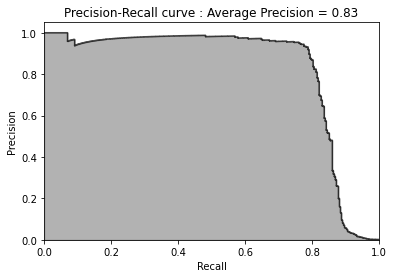

In [51]:
preds = pd.concat([y_train, predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel', 'prediction']
predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'], preds['prediction'])

average_precision = average_precision_score(preds['trueLabel'], preds['prediction'])

plt.step(recall, precision, color='k', alpha = 0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha = 0.3, color = 'k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve : Average Precision = {0:0.2f}'.format(average_precision))

> 그레디언트 부스팅 모델의 평균 정밀도는 0.83으로 랜덤 포레스트 모델의 정밀도인 0.79와 조금 차이나는 수준이지만 로지스틱 회귀 모델의 정밀도인 0.73보다는 우수합니다. 

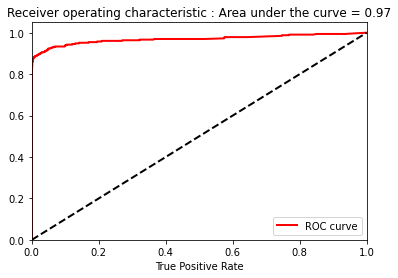

In [52]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'], preds['prediction'])

areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color = 'r', lw=2, label = 'ROC curve')
plt.plot([0,1], [0, 1], color='k', lw=2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('Receiver operating characteristic : Area under the curve = {0:0.2f}'.format(areaUnderROC))

plt.legend(loc = 'lower right')
plt.show()

> ROC 아래 면적은 0.97로 로지스틱 회귀 모델과 동일하며 랜덤 포레스트 모델 보다는 개선됐습니다. 현재까지 그레디언트 부스팅 모델이 로그손실, 정밀도-재현율곡선, AUROC 면적을 기준으로 세 모델 중 가장 좋습니다. 

### 10. 머신러닝 모델(4)

##### 1) LightGBM

In [53]:
# 하이퍼파라미터 설정하기
params_lightGB = {
    'task' : 'train',
    'application' : 'binary',
    'num_class' : 1,
    'boosting' : 'gbdt',
    'objective' : 'binary',
    'metric': 'binary_logloss',
    'metric_freq' : 50,
    'is_training_metric' : False,
    'max_depth' : 4,
    'num_leaves' : 31,
    'learning_rate' : 0.01,
    'feature_fraction' : 1.0,
    'bagging_fraction' : 1.0,
    'bagging_freq' : 0,
    'bagging_seed' : 2018,
    'verbose' : 0,
    'num_threads' : 16
}

##### 2) 모델 훈련시키기

In [54]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],
                                    index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)),
                                          y_train.ravel()):
    x_train_fold, x_cv_fold = x_train.iloc[train_index,:], \
        x_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], \
        y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_cv_fold, y_cv_fold, reference=lgb_train)
    
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000, 
                    valid_sets = lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(x_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[x_cv_fold.index,'prediction'] = \
        gbm.predict(x_cv_fold, num_iteration=gbm.best_iteration)
    loglossCV = log_loss(y_cv_fold, \
        predictionsBasedOnKFolds.loc[x_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMtGradientBoosting = \
    log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('XGBoost Gradient Boosting Log Loss: ', loglossLightGBMtGradientBoosting)

[1]	valid_0's binary_logloss: 0.00634115
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00627492
[3]	valid_0's binary_logloss: 0.00620527
[4]	valid_0's binary_logloss: 0.00616014
[5]	valid_0's binary_logloss: 0.00609608
[6]	valid_0's binary_logloss: 0.0060474
[7]	valid_0's binary_logloss: 0.0059922
[8]	valid_0's binary_logloss: 0.00593688
[9]	valid_0's binary_logloss: 0.00588275
[10]	valid_0's binary_logloss: 0.00582962
[11]	valid_0's binary_logloss: 0.00577838
[12]	valid_0's binary_logloss: 0.00573037
[13]	valid_0's binary_logloss: 0.00568343
[14]	valid_0's binary_logloss: 0.00563845
[15]	valid_0's binary_logloss: 0.00559177
[16]	valid_0's binary_logloss: 0.00554777
[17]	valid_0's binary_logloss: 0.00550471
[18]	valid_0's binary_logloss: 0.00546175
[19]	valid_0's binary_logloss: 0.00542175
[20]	valid_0's binary_logloss: 0.00538166
[21]	valid_0's binary_logloss: 0.00534326
[22]	valid_0's binary_logloss: 0.00530349
[23]	valid_0's binary_lo

[205]	valid_0's binary_logloss: 0.00301537
[206]	valid_0's binary_logloss: 0.00301267
[207]	valid_0's binary_logloss: 0.00300808
[208]	valid_0's binary_logloss: 0.00300537
[209]	valid_0's binary_logloss: 0.00300409
[210]	valid_0's binary_logloss: 0.00299942
[211]	valid_0's binary_logloss: 0.00299826
[212]	valid_0's binary_logloss: 0.00299417
[213]	valid_0's binary_logloss: 0.00299162
[214]	valid_0's binary_logloss: 0.00299028
[215]	valid_0's binary_logloss: 0.00298514
[216]	valid_0's binary_logloss: 0.00298262
[217]	valid_0's binary_logloss: 0.00298179
[218]	valid_0's binary_logloss: 0.00297867
[219]	valid_0's binary_logloss: 0.00297626
[220]	valid_0's binary_logloss: 0.0029754
[221]	valid_0's binary_logloss: 0.00297057
[222]	valid_0's binary_logloss: 0.00296827
[223]	valid_0's binary_logloss: 0.00296446
[224]	valid_0's binary_logloss: 0.00296214
[225]	valid_0's binary_logloss: 0.00296092
[226]	valid_0's binary_logloss: 0.00295794
[227]	valid_0's binary_logloss: 0.00295576
[228]	valid_

[400]	valid_0's binary_logloss: 0.00273127
[401]	valid_0's binary_logloss: 0.00273112
[402]	valid_0's binary_logloss: 0.00273044
[403]	valid_0's binary_logloss: 0.00272883
[404]	valid_0's binary_logloss: 0.00272843
[405]	valid_0's binary_logloss: 0.00272701
[406]	valid_0's binary_logloss: 0.00272636
[407]	valid_0's binary_logloss: 0.00272601
[408]	valid_0's binary_logloss: 0.0027249
[409]	valid_0's binary_logloss: 0.00272441
[410]	valid_0's binary_logloss: 0.00272429
[411]	valid_0's binary_logloss: 0.00272406
[412]	valid_0's binary_logloss: 0.00272231
[413]	valid_0's binary_logloss: 0.00271983
[414]	valid_0's binary_logloss: 0.00271813
[415]	valid_0's binary_logloss: 0.0027186
[416]	valid_0's binary_logloss: 0.00271696
[417]	valid_0's binary_logloss: 0.00271746
[418]	valid_0's binary_logloss: 0.00271794
[419]	valid_0's binary_logloss: 0.00271667
[420]	valid_0's binary_logloss: 0.00271565
[421]	valid_0's binary_logloss: 0.00271503
[422]	valid_0's binary_logloss: 0.00271432
[423]	valid_0

[594]	valid_0's binary_logloss: 0.00265458
[595]	valid_0's binary_logloss: 0.00265455
[596]	valid_0's binary_logloss: 0.00265484
[597]	valid_0's binary_logloss: 0.00265492
[598]	valid_0's binary_logloss: 0.00265493
[599]	valid_0's binary_logloss: 0.00265488
[600]	valid_0's binary_logloss: 0.00265605
[601]	valid_0's binary_logloss: 0.00265494
[602]	valid_0's binary_logloss: 0.00265502
[603]	valid_0's binary_logloss: 0.00265559
[604]	valid_0's binary_logloss: 0.00265542
[605]	valid_0's binary_logloss: 0.00265568
[606]	valid_0's binary_logloss: 0.00265646
[607]	valid_0's binary_logloss: 0.00265761
[608]	valid_0's binary_logloss: 0.00265776
[609]	valid_0's binary_logloss: 0.00265748
[610]	valid_0's binary_logloss: 0.00265684
[611]	valid_0's binary_logloss: 0.00265653
[612]	valid_0's binary_logloss: 0.00265505
[613]	valid_0's binary_logloss: 0.00265535
[614]	valid_0's binary_logloss: 0.00265532
[615]	valid_0's binary_logloss: 0.00265424
[616]	valid_0's binary_logloss: 0.00265483
[617]	valid

[796]	valid_0's binary_logloss: 0.00264235
[797]	valid_0's binary_logloss: 0.00264217
[798]	valid_0's binary_logloss: 0.00264077
[799]	valid_0's binary_logloss: 0.00264074
[800]	valid_0's binary_logloss: 0.00264105
[801]	valid_0's binary_logloss: 0.00263951
[802]	valid_0's binary_logloss: 0.00263878
[803]	valid_0's binary_logloss: 0.00263893
[804]	valid_0's binary_logloss: 0.00263878
[805]	valid_0's binary_logloss: 0.00263877
[806]	valid_0's binary_logloss: 0.00263907
[807]	valid_0's binary_logloss: 0.00263839
[808]	valid_0's binary_logloss: 0.00263744
[809]	valid_0's binary_logloss: 0.00263723
[810]	valid_0's binary_logloss: 0.00263768
[811]	valid_0's binary_logloss: 0.0026378
[812]	valid_0's binary_logloss: 0.0026371
[813]	valid_0's binary_logloss: 0.00263694
[814]	valid_0's binary_logloss: 0.00263682
[815]	valid_0's binary_logloss: 0.00263688
[816]	valid_0's binary_logloss: 0.002637
[817]	valid_0's binary_logloss: 0.00263728
[818]	valid_0's binary_logloss: 0.00263659
[819]	valid_0's

[998]	valid_0's binary_logloss: 0.00261106
[999]	valid_0's binary_logloss: 0.00261171
[1000]	valid_0's binary_logloss: 0.00261147
[1001]	valid_0's binary_logloss: 0.00261011
[1002]	valid_0's binary_logloss: 0.00261022
[1003]	valid_0's binary_logloss: 0.00260972
[1004]	valid_0's binary_logloss: 0.00261011
[1005]	valid_0's binary_logloss: 0.00260992
[1006]	valid_0's binary_logloss: 0.00261056
[1007]	valid_0's binary_logloss: 0.00261002
[1008]	valid_0's binary_logloss: 0.0026101
[1009]	valid_0's binary_logloss: 0.00261017
[1010]	valid_0's binary_logloss: 0.00260975
[1011]	valid_0's binary_logloss: 0.00260982
[1012]	valid_0's binary_logloss: 0.00260961
[1013]	valid_0's binary_logloss: 0.00260972
[1014]	valid_0's binary_logloss: 0.00260908
[1015]	valid_0's binary_logloss: 0.0026093
[1016]	valid_0's binary_logloss: 0.00260857
[1017]	valid_0's binary_logloss: 0.00260923
[1018]	valid_0's binary_logloss: 0.00260883
[1019]	valid_0's binary_logloss: 0.00260949
[1020]	valid_0's binary_logloss: 0.0

[1185]	valid_0's binary_logloss: 0.00262274
[1186]	valid_0's binary_logloss: 0.00262242
[1187]	valid_0's binary_logloss: 0.00262223
[1188]	valid_0's binary_logloss: 0.0026223
[1189]	valid_0's binary_logloss: 0.00262312
[1190]	valid_0's binary_logloss: 0.00262294
[1191]	valid_0's binary_logloss: 0.00262335
[1192]	valid_0's binary_logloss: 0.00262317
[1193]	valid_0's binary_logloss: 0.00262386
[1194]	valid_0's binary_logloss: 0.0026232
[1195]	valid_0's binary_logloss: 0.00262299
[1196]	valid_0's binary_logloss: 0.00262256
[1197]	valid_0's binary_logloss: 0.00262314
[1198]	valid_0's binary_logloss: 0.00262252
[1199]	valid_0's binary_logloss: 0.00262222
[1200]	valid_0's binary_logloss: 0.00262224
[1201]	valid_0's binary_logloss: 0.00262214
[1202]	valid_0's binary_logloss: 0.00262146
[1203]	valid_0's binary_logloss: 0.00262205
[1204]	valid_0's binary_logloss: 0.00262282
[1205]	valid_0's binary_logloss: 0.00262267
[1206]	valid_0's binary_logloss: 0.00262239
[1207]	valid_0's binary_logloss: 0

[167]	valid_0's binary_logloss: 0.00332722
[168]	valid_0's binary_logloss: 0.0033233
[169]	valid_0's binary_logloss: 0.00331951
[170]	valid_0's binary_logloss: 0.00331599
[171]	valid_0's binary_logloss: 0.00331132
[172]	valid_0's binary_logloss: 0.00330756
[173]	valid_0's binary_logloss: 0.00330377
[174]	valid_0's binary_logloss: 0.0032997
[175]	valid_0's binary_logloss: 0.00329614
[176]	valid_0's binary_logloss: 0.00329162
[177]	valid_0's binary_logloss: 0.00328756
[178]	valid_0's binary_logloss: 0.00328345
[179]	valid_0's binary_logloss: 0.00328048
[180]	valid_0's binary_logloss: 0.00327662
[181]	valid_0's binary_logloss: 0.00327328
[182]	valid_0's binary_logloss: 0.00327036
[183]	valid_0's binary_logloss: 0.00326674
[184]	valid_0's binary_logloss: 0.00326191
[185]	valid_0's binary_logloss: 0.0032576
[186]	valid_0's binary_logloss: 0.00325398
[187]	valid_0's binary_logloss: 0.00324998
[188]	valid_0's binary_logloss: 0.00324663
[189]	valid_0's binary_logloss: 0.0032432
[190]	valid_0's

[362]	valid_0's binary_logloss: 0.00297939
[363]	valid_0's binary_logloss: 0.00297901
[364]	valid_0's binary_logloss: 0.00297916
[365]	valid_0's binary_logloss: 0.00297892
[366]	valid_0's binary_logloss: 0.00297955
[367]	valid_0's binary_logloss: 0.00297977
[368]	valid_0's binary_logloss: 0.00297941
[369]	valid_0's binary_logloss: 0.00297909
[370]	valid_0's binary_logloss: 0.00297757
[371]	valid_0's binary_logloss: 0.00297619
[372]	valid_0's binary_logloss: 0.00297632
[373]	valid_0's binary_logloss: 0.00297613
[374]	valid_0's binary_logloss: 0.00297578
[375]	valid_0's binary_logloss: 0.00297556
[376]	valid_0's binary_logloss: 0.00297534
[377]	valid_0's binary_logloss: 0.00297429
[378]	valid_0's binary_logloss: 0.00297454
[379]	valid_0's binary_logloss: 0.0029744
[380]	valid_0's binary_logloss: 0.00297469
[381]	valid_0's binary_logloss: 0.00297489
[382]	valid_0's binary_logloss: 0.00297482
[383]	valid_0's binary_logloss: 0.00297463
[384]	valid_0's binary_logloss: 0.00297443
[385]	valid_

[557]	valid_0's binary_logloss: 0.00292868
[558]	valid_0's binary_logloss: 0.00292845
[559]	valid_0's binary_logloss: 0.00292826
[560]	valid_0's binary_logloss: 0.00292807
[561]	valid_0's binary_logloss: 0.0029266
[562]	valid_0's binary_logloss: 0.00292769
[563]	valid_0's binary_logloss: 0.0029275
[564]	valid_0's binary_logloss: 0.00292708
[565]	valid_0's binary_logloss: 0.00292466
[566]	valid_0's binary_logloss: 0.00292519
[567]	valid_0's binary_logloss: 0.00292507
[568]	valid_0's binary_logloss: 0.00292477
[569]	valid_0's binary_logloss: 0.00292337
[570]	valid_0's binary_logloss: 0.00292338
[571]	valid_0's binary_logloss: 0.0029243
[572]	valid_0's binary_logloss: 0.00292366
[573]	valid_0's binary_logloss: 0.00292316
[574]	valid_0's binary_logloss: 0.00292489
[575]	valid_0's binary_logloss: 0.00292465
[576]	valid_0's binary_logloss: 0.00292415
[577]	valid_0's binary_logloss: 0.00292523
[578]	valid_0's binary_logloss: 0.00292528
[579]	valid_0's binary_logloss: 0.00292515
[580]	valid_0'

[760]	valid_0's binary_logloss: 0.00292214
[761]	valid_0's binary_logloss: 0.00292204
[762]	valid_0's binary_logloss: 0.00292275
[763]	valid_0's binary_logloss: 0.00292198
[764]	valid_0's binary_logloss: 0.00292232
[765]	valid_0's binary_logloss: 0.00292214
[766]	valid_0's binary_logloss: 0.00292319
[767]	valid_0's binary_logloss: 0.00292357
[768]	valid_0's binary_logloss: 0.00292322
[769]	valid_0's binary_logloss: 0.00292304
[770]	valid_0's binary_logloss: 0.00292292
[771]	valid_0's binary_logloss: 0.0029233
[772]	valid_0's binary_logloss: 0.00292434
[773]	valid_0's binary_logloss: 0.00292533
[774]	valid_0's binary_logloss: 0.00292638
[775]	valid_0's binary_logloss: 0.00292544
[776]	valid_0's binary_logloss: 0.00292577
[777]	valid_0's binary_logloss: 0.00292509
[778]	valid_0's binary_logloss: 0.00292508
[779]	valid_0's binary_logloss: 0.00292581
[780]	valid_0's binary_logloss: 0.0029263
[781]	valid_0's binary_logloss: 0.00292591
[782]	valid_0's binary_logloss: 0.00292697
[783]	valid_0

[1]	valid_0's binary_logloss: 0.00598384
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00591096
[3]	valid_0's binary_logloss: 0.00582392
[4]	valid_0's binary_logloss: 0.00574865
[5]	valid_0's binary_logloss: 0.00567836
[6]	valid_0's binary_logloss: 0.00559443
[7]	valid_0's binary_logloss: 0.00550457
[8]	valid_0's binary_logloss: 0.00544018
[9]	valid_0's binary_logloss: 0.00536756
[10]	valid_0's binary_logloss: 0.0053157
[11]	valid_0's binary_logloss: 0.00526181
[12]	valid_0's binary_logloss: 0.00520665
[13]	valid_0's binary_logloss: 0.00515495
[14]	valid_0's binary_logloss: 0.00511009
[15]	valid_0's binary_logloss: 0.00506738
[16]	valid_0's binary_logloss: 0.00502552
[17]	valid_0's binary_logloss: 0.00497765
[18]	valid_0's binary_logloss: 0.00493184
[19]	valid_0's binary_logloss: 0.00488708
[20]	valid_0's binary_logloss: 0.00484414
[21]	valid_0's binary_logloss: 0.00480165
[22]	valid_0's binary_logloss: 0.00475938
[23]	valid_0's binary_l

[204]	valid_0's binary_logloss: 0.00261107
[205]	valid_0's binary_logloss: 0.00260842
[206]	valid_0's binary_logloss: 0.00260526
[207]	valid_0's binary_logloss: 0.0026029
[208]	valid_0's binary_logloss: 0.00259988
[209]	valid_0's binary_logloss: 0.00259801
[210]	valid_0's binary_logloss: 0.00259565
[211]	valid_0's binary_logloss: 0.00259213
[212]	valid_0's binary_logloss: 0.00259003
[213]	valid_0's binary_logloss: 0.00258814
[214]	valid_0's binary_logloss: 0.00258542
[215]	valid_0's binary_logloss: 0.00258107
[216]	valid_0's binary_logloss: 0.00257903
[217]	valid_0's binary_logloss: 0.00257602
[218]	valid_0's binary_logloss: 0.00257377
[219]	valid_0's binary_logloss: 0.00257211
[220]	valid_0's binary_logloss: 0.00256995
[221]	valid_0's binary_logloss: 0.0025658
[222]	valid_0's binary_logloss: 0.00256298
[223]	valid_0's binary_logloss: 0.00256132
[224]	valid_0's binary_logloss: 0.00255915
[225]	valid_0's binary_logloss: 0.00255646
[226]	valid_0's binary_logloss: 0.00255458
[227]	valid_0

[399]	valid_0's binary_logloss: 0.00238666
[400]	valid_0's binary_logloss: 0.00238645
[401]	valid_0's binary_logloss: 0.00238624
[402]	valid_0's binary_logloss: 0.00238419
[403]	valid_0's binary_logloss: 0.00238388
[404]	valid_0's binary_logloss: 0.00238378
[405]	valid_0's binary_logloss: 0.00238358
[406]	valid_0's binary_logloss: 0.00238289
[407]	valid_0's binary_logloss: 0.00238281
[408]	valid_0's binary_logloss: 0.00238194
[409]	valid_0's binary_logloss: 0.00238158
[410]	valid_0's binary_logloss: 0.00238141
[411]	valid_0's binary_logloss: 0.00238081
[412]	valid_0's binary_logloss: 0.00237998
[413]	valid_0's binary_logloss: 0.00237985
[414]	valid_0's binary_logloss: 0.00237928
[415]	valid_0's binary_logloss: 0.00237865
[416]	valid_0's binary_logloss: 0.00237852
[417]	valid_0's binary_logloss: 0.00237798
[418]	valid_0's binary_logloss: 0.00237786
[419]	valid_0's binary_logloss: 0.00237782
[420]	valid_0's binary_logloss: 0.0023772
[421]	valid_0's binary_logloss: 0.00237756
[422]	valid_

[594]	valid_0's binary_logloss: 0.002314
[595]	valid_0's binary_logloss: 0.00231421
[596]	valid_0's binary_logloss: 0.0023144
[597]	valid_0's binary_logloss: 0.00231417
[598]	valid_0's binary_logloss: 0.00231408
[599]	valid_0's binary_logloss: 0.00231432
[600]	valid_0's binary_logloss: 0.00231458
[601]	valid_0's binary_logloss: 0.00231457
[602]	valid_0's binary_logloss: 0.00231361
[603]	valid_0's binary_logloss: 0.0023136
[604]	valid_0's binary_logloss: 0.00231336
[605]	valid_0's binary_logloss: 0.00231378
[606]	valid_0's binary_logloss: 0.00231389
[607]	valid_0's binary_logloss: 0.00231295
[608]	valid_0's binary_logloss: 0.00231298
[609]	valid_0's binary_logloss: 0.00231279
[610]	valid_0's binary_logloss: 0.00231272
[611]	valid_0's binary_logloss: 0.00231315
[612]	valid_0's binary_logloss: 0.00231215
[613]	valid_0's binary_logloss: 0.00231222
[614]	valid_0's binary_logloss: 0.00231133
[615]	valid_0's binary_logloss: 0.00231144
[616]	valid_0's binary_logloss: 0.00231139
[617]	valid_0's

[788]	valid_0's binary_logloss: 0.0023041
[789]	valid_0's binary_logloss: 0.00230349
[790]	valid_0's binary_logloss: 0.00230377
[791]	valid_0's binary_logloss: 0.00230432
[792]	valid_0's binary_logloss: 0.00230482
[793]	valid_0's binary_logloss: 0.00230511
[794]	valid_0's binary_logloss: 0.00230454
[795]	valid_0's binary_logloss: 0.00230446
[796]	valid_0's binary_logloss: 0.00230417
[797]	valid_0's binary_logloss: 0.00230424
[798]	valid_0's binary_logloss: 0.00230416
[799]	valid_0's binary_logloss: 0.00230374
[800]	valid_0's binary_logloss: 0.0023037
[801]	valid_0's binary_logloss: 0.00230284
[802]	valid_0's binary_logloss: 0.00230324
[803]	valid_0's binary_logloss: 0.00230416
[804]	valid_0's binary_logloss: 0.00230405
[805]	valid_0's binary_logloss: 0.00230352
[806]	valid_0's binary_logloss: 0.00230398
[807]	valid_0's binary_logloss: 0.00230514
[808]	valid_0's binary_logloss: 0.00230488
[809]	valid_0's binary_logloss: 0.00230531
[810]	valid_0's binary_logloss: 0.00230649
[811]	valid_0

[980]	valid_0's binary_logloss: 0.00231283
[981]	valid_0's binary_logloss: 0.00231271
[982]	valid_0's binary_logloss: 0.00231298
[983]	valid_0's binary_logloss: 0.00231381
[984]	valid_0's binary_logloss: 0.00231359
[985]	valid_0's binary_logloss: 0.00231405
[986]	valid_0's binary_logloss: 0.00231443
[987]	valid_0's binary_logloss: 0.00231442
[988]	valid_0's binary_logloss: 0.00231484
[989]	valid_0's binary_logloss: 0.00231511
[990]	valid_0's binary_logloss: 0.00231625
[991]	valid_0's binary_logloss: 0.00231686
[992]	valid_0's binary_logloss: 0.00231675
[993]	valid_0's binary_logloss: 0.00231661
[994]	valid_0's binary_logloss: 0.00231603
[995]	valid_0's binary_logloss: 0.00231631
[996]	valid_0's binary_logloss: 0.00231662
[997]	valid_0's binary_logloss: 0.00231724
[998]	valid_0's binary_logloss: 0.00231805
[999]	valid_0's binary_logloss: 0.00231799
[1000]	valid_0's binary_logloss: 0.00231773
[1001]	valid_0's binary_logloss: 0.00231853
Early stopping, best iteration is:
[801]	valid_0's b

[168]	valid_0's binary_logloss: 0.00311055
[169]	valid_0's binary_logloss: 0.00310662
[170]	valid_0's binary_logloss: 0.00310256
[171]	valid_0's binary_logloss: 0.00309831
[172]	valid_0's binary_logloss: 0.00309344
[173]	valid_0's binary_logloss: 0.00308955
[174]	valid_0's binary_logloss: 0.00308511
[175]	valid_0's binary_logloss: 0.00308183
[176]	valid_0's binary_logloss: 0.00307723
[177]	valid_0's binary_logloss: 0.00307219
[178]	valid_0's binary_logloss: 0.00306809
[179]	valid_0's binary_logloss: 0.00306407
[180]	valid_0's binary_logloss: 0.00305949
[181]	valid_0's binary_logloss: 0.00305567
[182]	valid_0's binary_logloss: 0.00305279
[183]	valid_0's binary_logloss: 0.00304857
[184]	valid_0's binary_logloss: 0.0030451
[185]	valid_0's binary_logloss: 0.00304191
[186]	valid_0's binary_logloss: 0.00303696
[187]	valid_0's binary_logloss: 0.00303351
[188]	valid_0's binary_logloss: 0.00302923
[189]	valid_0's binary_logloss: 0.00302595
[190]	valid_0's binary_logloss: 0.00302183
[191]	valid_

[369]	valid_0's binary_logloss: 0.00272115
[370]	valid_0's binary_logloss: 0.0027212
[371]	valid_0's binary_logloss: 0.00272093
[372]	valid_0's binary_logloss: 0.00272039
[373]	valid_0's binary_logloss: 0.00272083
[374]	valid_0's binary_logloss: 0.00272092
[375]	valid_0's binary_logloss: 0.00272115
[376]	valid_0's binary_logloss: 0.00272082
[377]	valid_0's binary_logloss: 0.00272069
[378]	valid_0's binary_logloss: 0.00272122
[379]	valid_0's binary_logloss: 0.00272075
[380]	valid_0's binary_logloss: 0.00272102
[381]	valid_0's binary_logloss: 0.0027214
[382]	valid_0's binary_logloss: 0.00272124
[383]	valid_0's binary_logloss: 0.0027208
[384]	valid_0's binary_logloss: 0.00272065
[385]	valid_0's binary_logloss: 0.00271846
[386]	valid_0's binary_logloss: 0.00271875
[387]	valid_0's binary_logloss: 0.0027186
[388]	valid_0's binary_logloss: 0.0027189
[389]	valid_0's binary_logloss: 0.00271892
[390]	valid_0's binary_logloss: 0.00271879
[391]	valid_0's binary_logloss: 0.00271959
[392]	valid_0's 

[571]	valid_0's binary_logloss: 0.00272212
[572]	valid_0's binary_logloss: 0.0027222
[573]	valid_0's binary_logloss: 0.00272225
[574]	valid_0's binary_logloss: 0.00272172
[575]	valid_0's binary_logloss: 0.00272203
[576]	valid_0's binary_logloss: 0.00272236
[577]	valid_0's binary_logloss: 0.00272218
[578]	valid_0's binary_logloss: 0.00272238
[579]	valid_0's binary_logloss: 0.00272175
[580]	valid_0's binary_logloss: 0.00272146
[581]	valid_0's binary_logloss: 0.00272191
[582]	valid_0's binary_logloss: 0.00272139
[583]	valid_0's binary_logloss: 0.00272174
[584]	valid_0's binary_logloss: 0.00272183
[585]	valid_0's binary_logloss: 0.00272229
[586]	valid_0's binary_logloss: 0.00272302
[587]	valid_0's binary_logloss: 0.00272377
[588]	valid_0's binary_logloss: 0.00272391
[589]	valid_0's binary_logloss: 0.00272416
[590]	valid_0's binary_logloss: 0.00272526
[591]	valid_0's binary_logloss: 0.00272605
[592]	valid_0's binary_logloss: 0.00272674
[593]	valid_0's binary_logloss: 0.00272687
[594]	valid_

[61]	valid_0's binary_logloss: 0.00479491
[62]	valid_0's binary_logloss: 0.00477689
[63]	valid_0's binary_logloss: 0.00476068
[64]	valid_0's binary_logloss: 0.00474398
[65]	valid_0's binary_logloss: 0.00472835
[66]	valid_0's binary_logloss: 0.00471235
[67]	valid_0's binary_logloss: 0.00469623
[68]	valid_0's binary_logloss: 0.00468345
[69]	valid_0's binary_logloss: 0.00466648
[70]	valid_0's binary_logloss: 0.00465201
[71]	valid_0's binary_logloss: 0.00463967
[72]	valid_0's binary_logloss: 0.00462531
[73]	valid_0's binary_logloss: 0.00461107
[74]	valid_0's binary_logloss: 0.00459917
[75]	valid_0's binary_logloss: 0.00458543
[76]	valid_0's binary_logloss: 0.004574
[77]	valid_0's binary_logloss: 0.00456025
[78]	valid_0's binary_logloss: 0.00454706
[79]	valid_0's binary_logloss: 0.0045354
[80]	valid_0's binary_logloss: 0.00452259
[81]	valid_0's binary_logloss: 0.00450857
[82]	valid_0's binary_logloss: 0.00449694
[83]	valid_0's binary_logloss: 0.00448496
[84]	valid_0's binary_logloss: 0.0044

[254]	valid_0's binary_logloss: 0.00374413
[255]	valid_0's binary_logloss: 0.00374364
[256]	valid_0's binary_logloss: 0.00374393
[257]	valid_0's binary_logloss: 0.00374117
[258]	valid_0's binary_logloss: 0.00373933
[259]	valid_0's binary_logloss: 0.00373903
[260]	valid_0's binary_logloss: 0.00373675
[261]	valid_0's binary_logloss: 0.0037348
[262]	valid_0's binary_logloss: 0.00373457
[263]	valid_0's binary_logloss: 0.00373408
[264]	valid_0's binary_logloss: 0.00373256
[265]	valid_0's binary_logloss: 0.00372968
[266]	valid_0's binary_logloss: 0.00372918
[267]	valid_0's binary_logloss: 0.00372692
[268]	valid_0's binary_logloss: 0.00372472
[269]	valid_0's binary_logloss: 0.00372428
[270]	valid_0's binary_logloss: 0.00372438
[271]	valid_0's binary_logloss: 0.00372168
[272]	valid_0's binary_logloss: 0.00372032
[273]	valid_0's binary_logloss: 0.0037196
[274]	valid_0's binary_logloss: 0.00371962
[275]	valid_0's binary_logloss: 0.00371699
[276]	valid_0's binary_logloss: 0.00371597
[277]	valid_0

[451]	valid_0's binary_logloss: 0.00361286
[452]	valid_0's binary_logloss: 0.00361224
[453]	valid_0's binary_logloss: 0.0036111
[454]	valid_0's binary_logloss: 0.00361129
[455]	valid_0's binary_logloss: 0.00361046
[456]	valid_0's binary_logloss: 0.00360947
[457]	valid_0's binary_logloss: 0.00361018
[458]	valid_0's binary_logloss: 0.00361096
[459]	valid_0's binary_logloss: 0.00361102
[460]	valid_0's binary_logloss: 0.00360993
[461]	valid_0's binary_logloss: 0.00360934
[462]	valid_0's binary_logloss: 0.00360826
[463]	valid_0's binary_logloss: 0.00360816
[464]	valid_0's binary_logloss: 0.00360763
[465]	valid_0's binary_logloss: 0.00360683
[466]	valid_0's binary_logloss: 0.00360688
[467]	valid_0's binary_logloss: 0.00360707
[468]	valid_0's binary_logloss: 0.00360699
[469]	valid_0's binary_logloss: 0.00360554
[470]	valid_0's binary_logloss: 0.00360612
[471]	valid_0's binary_logloss: 0.00360632
[472]	valid_0's binary_logloss: 0.00360581
[473]	valid_0's binary_logloss: 0.00360558
[474]	valid_

[647]	valid_0's binary_logloss: 0.00358553
[648]	valid_0's binary_logloss: 0.00358493
[649]	valid_0's binary_logloss: 0.00358626
[650]	valid_0's binary_logloss: 0.00358691
[651]	valid_0's binary_logloss: 0.00358554
[652]	valid_0's binary_logloss: 0.00358495
[653]	valid_0's binary_logloss: 0.00358627
[654]	valid_0's binary_logloss: 0.00358673
[655]	valid_0's binary_logloss: 0.00358614
[656]	valid_0's binary_logloss: 0.00358614
[657]	valid_0's binary_logloss: 0.00358511
[658]	valid_0's binary_logloss: 0.00358468
[659]	valid_0's binary_logloss: 0.00358472
[660]	valid_0's binary_logloss: 0.00358606
[661]	valid_0's binary_logloss: 0.00358595
[662]	valid_0's binary_logloss: 0.00358538
[663]	valid_0's binary_logloss: 0.00358618
[664]	valid_0's binary_logloss: 0.00358545
[665]	valid_0's binary_logloss: 0.00358524
[666]	valid_0's binary_logloss: 0.00358564
[667]	valid_0's binary_logloss: 0.00358508
[668]	valid_0's binary_logloss: 0.00358524
[669]	valid_0's binary_logloss: 0.00358525
[670]	valid

##### 3) 모델 결과 평가하기

Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.83')

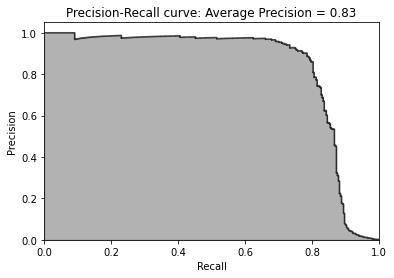

In [55]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = \
    precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = \
    average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

> 로그 손실은 XGBoost 모델의 로그 손실과 유사하며 랜덤 포레스트 모델의 1/5, 로지스틱 회귀 모델의 1/50 수준입니다. 그러나 수행 속도 관점에서 XGBoost와 비교하면 LightGBM이 훨씬 더 빠릅니다. 

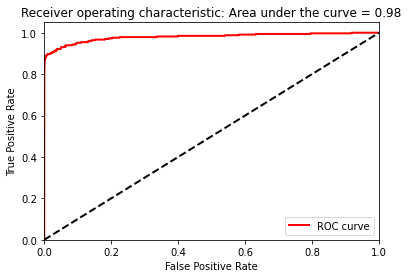

In [56]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

> auROC 면적은 0.98로 XGBoost 0.97 보다 개선됐습니다.

### 11. 테스트 데이터셋으로 4가지 모델 평가하기

In [59]:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[], index=y_test.index, columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:, 'prediction'] = logReg.predict_proba(x_test)[:,1]
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression)

predictionsTestSetRandomForests = pd.DataFrame(data=[], index=y_test.index, columns=['prediction'])
predictionsTestSetRandomForests.loc[:, 'prediction'] = RFC.predict_proba(x_test)[:,1]
logLossTestSetRandomForests = log_loss(y_test, predictionsTestSetRandomForests)

predictionsTestSetXGBoostGradientBoosting = pd.DataFrame(data=[], index=y_test.index, columns=['prediction'])
dtest = xgb.DMatrix(data=x_test)
predictionsTestSetXGBoostGradientBoosting.loc[:, 'prediction'] = bst.predict(dtest)
logLossTestSetXGBoostGradientBoosting = log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)

predictionsTestSetLightGBMGradientBoosting = pd.DataFrame(data=[], index=y_test.index, columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:, 'prediction'] = gbm.predict(x_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)

In [60]:
print("Log Loss of Logistic Regression on Test Set: ", logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", logLossTestSetRandomForests)
print("Log Loss of XGBoost Gradient Boosting on Test Set: ", logLossTestSetXGBoostGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", logLossTestSetLightGBMGradientBoosting)

Log Loss of Logistic Regression on Test Set:  0.09670036315787882
Log Loss of Random Forests on Test Set:  0.009018284462863804
Log Loss of XGBoost Gradient Boosting on Test Set:  0.002424374468390823
Log Loss of LightGBM Gradient Boosting on Test Set:  0.002516958317012632


> 테스트 데이터셋에서 로그 손실이 가장 낮은 모델은 XGBoost 그레디언트 모델입니다. 

### 12. 앙상블
- 일반적으로 서로 다른 머신러닝 알고리즘 계열(랜덤포레스트와 신경망)에서 성능이 비슷하고 강력한 솔루션이 있다면 이 솔루션들의 앙상블은 독립형 솔루션 중 그 어떤 것보다 더 나은 결과를 얻을 수 있습니다. 
- 이는 각 독립형 솔루션이 서로 다른 강점과 약점을 가지고 있기 때문입니다. 
- 하지만 솔루션 중 하나가 다른 솔루션보다 훨씬 성능이 좋다면 앙상블의 성능은 가장 성능이 좋은 독립형 솔루션의 성능과 동일합니다. 
- 또한 독립형 솔루션들은 상대적으로 상관관계가 없어야 합니다. 만약 상관관계가 매우 높다면 한 솔루션의 강점이 나머지 솔루션의 장점에 반영될거고 약점도 마찬가지일 겁니다. 이 경우, 앙상블을 통한 다양화로부터 얻는 혜택이 적을 겁니다.

##### 1) 스태킹
- 1. 스태킹할 때, 우선 k-겹 교차검증으로부터 4개의 독립형 모델 각각의 예측 결과 정보(첫번째 예측 레이어)를 가져와서 원본 훈련 데이터셋에 추가합니다.
- 2. 그런 다음 k-겹 교차검증을 사용해 이 원본 피처와 첫 번째 예측 레이어 데이터셋을 훈련시킵니다. 
- 3. 이렇게 하면 k-겹 교차검증의 새로운 예측정보가 생성되며 이를 두번째 예측 레이어라고 부르고, 이를 통해 독립형 모델에 비해 성능이 향상됐는지 확인할 수 있습니다.

##### 1-1) 첫 번째 예측 레이어와 원본 훈련 데이터셋 결합하기

In [66]:
predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[], index=y_train.index)
predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
    predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float),how='left').join(
    predictionsBasedOnKFoldsRandomForestsClassifier['prediction'].astype(float),how='left', rsuffix = "2").join(
    predictionsBasedOnKFoldsXGBoostGradientBoosting['prediction'].astype(float),how='left', rsuffix = "3").join(
    predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float),how='left', rsuffix = "4")

predictionsBasedOnKFoldsFourModels.columns = ['predsLR', 'predsRF', 'predsXGB', 'predLightGBM']

x_trainWithPredictions = x_train.merge(predictionsBasedOnKFoldsFourModels, left_index = True, right_index=True)

##### 1-2) 하이퍼파라미터 설정하기
- 가장 성능이 우수했던 머신러닝 알고리즘인 LightGBM 하이퍼파라미터는 이전과 동일하게 유지합니다.

In [68]:
params_lightGB = {
    'task' : 'train',
    'application' : 'binary',
    'num_class' : 1,
    'boosting' : 'gbdt',
    'objective' : 'binary',
    'metric': 'binary_logloss',
    'metric_freq' : 50,
    'is_training_metric' : False,
    'max_depth' : 4,
    'num_leaves' : 31,
    'learning_rate' : 0.01,
    'feature_fraction' : 1.0,
    'bagging_fraction' : 1.0,
    'bagging_freq' : 0,
    'bagging_seed' : 2018,
    'verbose' : 0,
    'num_threads' : 16
}

##### 1-3) 모델 훈련시키기
- 이전과 마찬가지로 k-겹 교차검증을 사용하고 다섯 개의 서로 다른 교차검증 데이터셋에 대해 사기 확률을 생성합니다.

In [74]:
trainingScores = []
cvScores = []
predictionsBasedOnKFoldsEnsemble = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(x_train)), y_train.ravel()):
    x_train_fold, x_cv_fold = x_trainWithPredictions.iloc[train_index,:], x_trainWithPredictions.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(x_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(x_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(x_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFoldsEnsemble.loc[x_cv_fold.index,'prediction'] = gbm.predict(x_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFoldsEnsemble.loc[x_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossEnsemble = log_loss(y_train, predictionsBasedOnKFoldsEnsemble.loc[:,'prediction'])
print('Ensemble Log Loss: ', loglossEnsemble)

[1]	valid_0's binary_logloss: 0.00557201
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.00550628
[3]	valid_0's binary_logloss: 0.0054512
[4]	valid_0's binary_logloss: 0.00539376
[5]	valid_0's binary_logloss: 0.00533994
[6]	valid_0's binary_logloss: 0.00529542
[7]	valid_0's binary_logloss: 0.00525235
[8]	valid_0's binary_logloss: 0.00521027
[9]	valid_0's binary_logloss: 0.00516937
[10]	valid_0's binary_logloss: 0.00512997
[11]	valid_0's binary_logloss: 0.00509221
[12]	valid_0's binary_logloss: 0.00505438
[13]	valid_0's binary_logloss: 0.00502065
[14]	valid_0's binary_logloss: 0.0049822
[15]	valid_0's binary_logloss: 0.00494777
[16]	valid_0's binary_logloss: 0.00490748
[17]	valid_0's binary_logloss: 0.0048744
[18]	valid_0's binary_logloss: 0.00483829
[19]	valid_0's binary_logloss: 0.00480291
[20]	valid_0's binary_logloss: 0.00477022
[21]	valid_0's binary_logloss: 0.00473892
[22]	valid_0's binary_logloss: 0.0047078
[23]	valid_0's binary_logl

[202]	valid_0's binary_logloss: 0.00281621
[203]	valid_0's binary_logloss: 0.00281273
[204]	valid_0's binary_logloss: 0.0028096
[205]	valid_0's binary_logloss: 0.00280774
[206]	valid_0's binary_logloss: 0.00280304
[207]	valid_0's binary_logloss: 0.0028015
[208]	valid_0's binary_logloss: 0.00279909
[209]	valid_0's binary_logloss: 0.00279687
[210]	valid_0's binary_logloss: 0.00279391
[211]	valid_0's binary_logloss: 0.00279187
[212]	valid_0's binary_logloss: 0.0027891
[213]	valid_0's binary_logloss: 0.00278704
[214]	valid_0's binary_logloss: 0.00278463
[215]	valid_0's binary_logloss: 0.00278158
[216]	valid_0's binary_logloss: 0.00277942
[217]	valid_0's binary_logloss: 0.00277466
[218]	valid_0's binary_logloss: 0.00277287
[219]	valid_0's binary_logloss: 0.00277079
[220]	valid_0's binary_logloss: 0.00276869
[221]	valid_0's binary_logloss: 0.00276695
[222]	valid_0's binary_logloss: 0.00276461
[223]	valid_0's binary_logloss: 0.00276253
[224]	valid_0's binary_logloss: 0.0027604
[225]	valid_0's

[399]	valid_0's binary_logloss: 0.00259728
[400]	valid_0's binary_logloss: 0.00259605
[401]	valid_0's binary_logloss: 0.00259512
[402]	valid_0's binary_logloss: 0.00259473
[403]	valid_0's binary_logloss: 0.00259419
[404]	valid_0's binary_logloss: 0.00259328
[405]	valid_0's binary_logloss: 0.00259208
[406]	valid_0's binary_logloss: 0.00259172
[407]	valid_0's binary_logloss: 0.00259127
[408]	valid_0's binary_logloss: 0.00259048
[409]	valid_0's binary_logloss: 0.00259
[410]	valid_0's binary_logloss: 0.00258948
[411]	valid_0's binary_logloss: 0.00258893
[412]	valid_0's binary_logloss: 0.00258816
[413]	valid_0's binary_logloss: 0.00258859
[414]	valid_0's binary_logloss: 0.00258741
[415]	valid_0's binary_logloss: 0.00258695
[416]	valid_0's binary_logloss: 0.00258623
[417]	valid_0's binary_logloss: 0.00258666
[418]	valid_0's binary_logloss: 0.00258618
[419]	valid_0's binary_logloss: 0.00258594
[420]	valid_0's binary_logloss: 0.00258478
[421]	valid_0's binary_logloss: 0.00258448
[422]	valid_0'

[592]	valid_0's binary_logloss: 0.00255868
[593]	valid_0's binary_logloss: 0.00255877
[594]	valid_0's binary_logloss: 0.00255869
[595]	valid_0's binary_logloss: 0.00255959
[596]	valid_0's binary_logloss: 0.00255945
[597]	valid_0's binary_logloss: 0.00255902
[598]	valid_0's binary_logloss: 0.00255939
[599]	valid_0's binary_logloss: 0.00255917
[600]	valid_0's binary_logloss: 0.00255927
[601]	valid_0's binary_logloss: 0.00255825
[602]	valid_0's binary_logloss: 0.00255804
[603]	valid_0's binary_logloss: 0.00255825
[604]	valid_0's binary_logloss: 0.002558
[605]	valid_0's binary_logloss: 0.00255668
[606]	valid_0's binary_logloss: 0.00255689
[607]	valid_0's binary_logloss: 0.00255676
[608]	valid_0's binary_logloss: 0.00255716
[609]	valid_0's binary_logloss: 0.00255617
[610]	valid_0's binary_logloss: 0.0025564
[611]	valid_0's binary_logloss: 0.00255523
[612]	valid_0's binary_logloss: 0.00255563
[613]	valid_0's binary_logloss: 0.00255678
[614]	valid_0's binary_logloss: 0.00255727
[615]	valid_0'

[790]	valid_0's binary_logloss: 0.00257715
[791]	valid_0's binary_logloss: 0.00257731
[792]	valid_0's binary_logloss: 0.00257747
[793]	valid_0's binary_logloss: 0.00257809
[794]	valid_0's binary_logloss: 0.00257821
[795]	valid_0's binary_logloss: 0.00257797
[796]	valid_0's binary_logloss: 0.00257832
[797]	valid_0's binary_logloss: 0.00257936
[798]	valid_0's binary_logloss: 0.00257869
[799]	valid_0's binary_logloss: 0.00257922
[800]	valid_0's binary_logloss: 0.00257944
[801]	valid_0's binary_logloss: 0.00258015
[802]	valid_0's binary_logloss: 0.00257947
[803]	valid_0's binary_logloss: 0.00258033
[804]	valid_0's binary_logloss: 0.00257996
[805]	valid_0's binary_logloss: 0.00258058
[806]	valid_0's binary_logloss: 0.00258107
[807]	valid_0's binary_logloss: 0.00258226
[808]	valid_0's binary_logloss: 0.00258241
[809]	valid_0's binary_logloss: 0.00258246
[810]	valid_0's binary_logloss: 0.00258178
[811]	valid_0's binary_logloss: 0.00258182
[812]	valid_0's binary_logloss: 0.00258179
[813]	valid

[128]	valid_0's binary_logloss: 0.00345402
[129]	valid_0's binary_logloss: 0.00344902
[130]	valid_0's binary_logloss: 0.00344236
[131]	valid_0's binary_logloss: 0.00343159
[132]	valid_0's binary_logloss: 0.00342502
[133]	valid_0's binary_logloss: 0.00341916
[134]	valid_0's binary_logloss: 0.0034125
[135]	valid_0's binary_logloss: 0.00340635
[136]	valid_0's binary_logloss: 0.00340059
[137]	valid_0's binary_logloss: 0.00339441
[138]	valid_0's binary_logloss: 0.00338854
[139]	valid_0's binary_logloss: 0.00338262
[140]	valid_0's binary_logloss: 0.00337713
[141]	valid_0's binary_logloss: 0.00337182
[142]	valid_0's binary_logloss: 0.00336705
[143]	valid_0's binary_logloss: 0.00336144
[144]	valid_0's binary_logloss: 0.00335596
[145]	valid_0's binary_logloss: 0.0033505
[146]	valid_0's binary_logloss: 0.00334492
[147]	valid_0's binary_logloss: 0.0033396
[148]	valid_0's binary_logloss: 0.00333467
[149]	valid_0's binary_logloss: 0.00332971
[150]	valid_0's binary_logloss: 0.00332455
[151]	valid_0'

[321]	valid_0's binary_logloss: 0.00302691
[322]	valid_0's binary_logloss: 0.00302645
[323]	valid_0's binary_logloss: 0.00302634
[324]	valid_0's binary_logloss: 0.00302556
[325]	valid_0's binary_logloss: 0.00302519
[326]	valid_0's binary_logloss: 0.00302587
[327]	valid_0's binary_logloss: 0.00302589
[328]	valid_0's binary_logloss: 0.00302533
[329]	valid_0's binary_logloss: 0.00302435
[330]	valid_0's binary_logloss: 0.00302507
[331]	valid_0's binary_logloss: 0.00302538
[332]	valid_0's binary_logloss: 0.00302478
[333]	valid_0's binary_logloss: 0.00302466
[334]	valid_0's binary_logloss: 0.00302332
[335]	valid_0's binary_logloss: 0.00302409
[336]	valid_0's binary_logloss: 0.00302414
[337]	valid_0's binary_logloss: 0.00302414
[338]	valid_0's binary_logloss: 0.00302379
[339]	valid_0's binary_logloss: 0.00302252
[340]	valid_0's binary_logloss: 0.00302221
[341]	valid_0's binary_logloss: 0.00302065
[342]	valid_0's binary_logloss: 0.00302147
[343]	valid_0's binary_logloss: 0.00302187
[344]	valid

[516]	valid_0's binary_logloss: 0.00311813
[517]	valid_0's binary_logloss: 0.00311796
[518]	valid_0's binary_logloss: 0.00311935
[519]	valid_0's binary_logloss: 0.0031198
[520]	valid_0's binary_logloss: 0.00311963
[521]	valid_0's binary_logloss: 0.00311962
[522]	valid_0's binary_logloss: 0.00312016
[523]	valid_0's binary_logloss: 0.00312119
[524]	valid_0's binary_logloss: 0.00312166
[525]	valid_0's binary_logloss: 0.0031215
[526]	valid_0's binary_logloss: 0.00312223
[527]	valid_0's binary_logloss: 0.00312229
[528]	valid_0's binary_logloss: 0.0031217
[529]	valid_0's binary_logloss: 0.00312146
[530]	valid_0's binary_logloss: 0.00312207
[531]	valid_0's binary_logloss: 0.00312193
[532]	valid_0's binary_logloss: 0.00312178
[533]	valid_0's binary_logloss: 0.00312212
[534]	valid_0's binary_logloss: 0.00312236
[535]	valid_0's binary_logloss: 0.00312312
[536]	valid_0's binary_logloss: 0.00312299
[537]	valid_0's binary_logloss: 0.00312356
[538]	valid_0's binary_logloss: 0.00312408
[539]	valid_0'

[149]	valid_0's binary_logloss: 0.00285542
[150]	valid_0's binary_logloss: 0.00285101
[151]	valid_0's binary_logloss: 0.00284613
[152]	valid_0's binary_logloss: 0.00284164
[153]	valid_0's binary_logloss: 0.00283727
[154]	valid_0's binary_logloss: 0.0028331
[155]	valid_0's binary_logloss: 0.00282936
[156]	valid_0's binary_logloss: 0.00282514
[157]	valid_0's binary_logloss: 0.00282109
[158]	valid_0's binary_logloss: 0.00281696
[159]	valid_0's binary_logloss: 0.00281363
[160]	valid_0's binary_logloss: 0.00281009
[161]	valid_0's binary_logloss: 0.00280616
[162]	valid_0's binary_logloss: 0.00280286
[163]	valid_0's binary_logloss: 0.00279941
[164]	valid_0's binary_logloss: 0.00279623
[165]	valid_0's binary_logloss: 0.00279255
[166]	valid_0's binary_logloss: 0.00278928
[167]	valid_0's binary_logloss: 0.00278629
[168]	valid_0's binary_logloss: 0.00278245
[169]	valid_0's binary_logloss: 0.00277876
[170]	valid_0's binary_logloss: 0.00277588
[171]	valid_0's binary_logloss: 0.00277294
[172]	valid_

[350]	valid_0's binary_logloss: 0.00255917
[351]	valid_0's binary_logloss: 0.00255822
[352]	valid_0's binary_logloss: 0.00255776
[353]	valid_0's binary_logloss: 0.00255724
[354]	valid_0's binary_logloss: 0.00255724
[355]	valid_0's binary_logloss: 0.00255638
[356]	valid_0's binary_logloss: 0.00255649
[357]	valid_0's binary_logloss: 0.00255589
[358]	valid_0's binary_logloss: 0.00255549
[359]	valid_0's binary_logloss: 0.00255516
[360]	valid_0's binary_logloss: 0.00255415
[361]	valid_0's binary_logloss: 0.00255377
[362]	valid_0's binary_logloss: 0.00255351
[363]	valid_0's binary_logloss: 0.00255313
[364]	valid_0's binary_logloss: 0.00255313
[365]	valid_0's binary_logloss: 0.00255262
[366]	valid_0's binary_logloss: 0.00255246
[367]	valid_0's binary_logloss: 0.00255193
[368]	valid_0's binary_logloss: 0.00255165
[369]	valid_0's binary_logloss: 0.00255168
[370]	valid_0's binary_logloss: 0.00255014
[371]	valid_0's binary_logloss: 0.00255047
[372]	valid_0's binary_logloss: 0.00254725
[373]	valid

[545]	valid_0's binary_logloss: 0.00249467
[546]	valid_0's binary_logloss: 0.00249522
[547]	valid_0's binary_logloss: 0.00249537
[548]	valid_0's binary_logloss: 0.00249521
[549]	valid_0's binary_logloss: 0.00249451
[550]	valid_0's binary_logloss: 0.00249427
[551]	valid_0's binary_logloss: 0.00249443
[552]	valid_0's binary_logloss: 0.00249425
[553]	valid_0's binary_logloss: 0.00249401
[554]	valid_0's binary_logloss: 0.00249418
[555]	valid_0's binary_logloss: 0.0024924
[556]	valid_0's binary_logloss: 0.00249267
[557]	valid_0's binary_logloss: 0.00249242
[558]	valid_0's binary_logloss: 0.00249244
[559]	valid_0's binary_logloss: 0.0024928
[560]	valid_0's binary_logloss: 0.00249291
[561]	valid_0's binary_logloss: 0.00249351
[562]	valid_0's binary_logloss: 0.00249337
[563]	valid_0's binary_logloss: 0.00249323
[564]	valid_0's binary_logloss: 0.00249345
[565]	valid_0's binary_logloss: 0.00249363
[566]	valid_0's binary_logloss: 0.0024928
[567]	valid_0's binary_logloss: 0.00249257
[568]	valid_0'

[742]	valid_0's binary_logloss: 0.00249564
[743]	valid_0's binary_logloss: 0.00249559
[744]	valid_0's binary_logloss: 0.00249515
[745]	valid_0's binary_logloss: 0.00249499
[746]	valid_0's binary_logloss: 0.00249475
[747]	valid_0's binary_logloss: 0.00249489
[748]	valid_0's binary_logloss: 0.00249485
[749]	valid_0's binary_logloss: 0.00249438
[750]	valid_0's binary_logloss: 0.00249497
[751]	valid_0's binary_logloss: 0.00249462
[752]	valid_0's binary_logloss: 0.00249498
[753]	valid_0's binary_logloss: 0.00249455
[754]	valid_0's binary_logloss: 0.00249541
[755]	valid_0's binary_logloss: 0.00249583
[756]	valid_0's binary_logloss: 0.00249549
[757]	valid_0's binary_logloss: 0.0024954
[758]	valid_0's binary_logloss: 0.00249511
[759]	valid_0's binary_logloss: 0.00249582
[760]	valid_0's binary_logloss: 0.00249651
[761]	valid_0's binary_logloss: 0.00249691
[762]	valid_0's binary_logloss: 0.00249726
[763]	valid_0's binary_logloss: 0.00249797
[764]	valid_0's binary_logloss: 0.00249827
[765]	valid_

[287]	valid_0's binary_logloss: 0.00260958
[288]	valid_0's binary_logloss: 0.00260834
[289]	valid_0's binary_logloss: 0.00260777
[290]	valid_0's binary_logloss: 0.00260761
[291]	valid_0's binary_logloss: 0.00260677
[292]	valid_0's binary_logloss: 0.00260575
[293]	valid_0's binary_logloss: 0.0026049
[294]	valid_0's binary_logloss: 0.00260417
[295]	valid_0's binary_logloss: 0.00260314
[296]	valid_0's binary_logloss: 0.00260206
[297]	valid_0's binary_logloss: 0.00260127
[298]	valid_0's binary_logloss: 0.00260022
[299]	valid_0's binary_logloss: 0.00259977
[300]	valid_0's binary_logloss: 0.00259853
[301]	valid_0's binary_logloss: 0.00259779
[302]	valid_0's binary_logloss: 0.00259702
[303]	valid_0's binary_logloss: 0.00259622
[304]	valid_0's binary_logloss: 0.00259515
[305]	valid_0's binary_logloss: 0.0025942
[306]	valid_0's binary_logloss: 0.00259351
[307]	valid_0's binary_logloss: 0.00259278
[308]	valid_0's binary_logloss: 0.00259249
[309]	valid_0's binary_logloss: 0.00259181
[310]	valid_0

[485]	valid_0's binary_logloss: 0.00255908
[486]	valid_0's binary_logloss: 0.00255857
[487]	valid_0's binary_logloss: 0.0025592
[488]	valid_0's binary_logloss: 0.00255967
[489]	valid_0's binary_logloss: 0.00256062
[490]	valid_0's binary_logloss: 0.00256092
[491]	valid_0's binary_logloss: 0.00256183
[492]	valid_0's binary_logloss: 0.00256224
[493]	valid_0's binary_logloss: 0.00256175
[494]	valid_0's binary_logloss: 0.00256276
[495]	valid_0's binary_logloss: 0.00256275
[496]	valid_0's binary_logloss: 0.00256331
[497]	valid_0's binary_logloss: 0.00256312
[498]	valid_0's binary_logloss: 0.00256376
[499]	valid_0's binary_logloss: 0.00256365
[500]	valid_0's binary_logloss: 0.00256384
[501]	valid_0's binary_logloss: 0.00256452
[502]	valid_0's binary_logloss: 0.00256566
[503]	valid_0's binary_logloss: 0.00256512
[504]	valid_0's binary_logloss: 0.00256482
[505]	valid_0's binary_logloss: 0.00256497
[506]	valid_0's binary_logloss: 0.00256561
[507]	valid_0's binary_logloss: 0.00256532
[508]	valid_

[62]	valid_0's binary_logloss: 0.00441318
[63]	valid_0's binary_logloss: 0.00439926
[64]	valid_0's binary_logloss: 0.00438593
[65]	valid_0's binary_logloss: 0.00437206
[66]	valid_0's binary_logloss: 0.00435803
[67]	valid_0's binary_logloss: 0.00434453
[68]	valid_0's binary_logloss: 0.00433145
[69]	valid_0's binary_logloss: 0.00431717
[70]	valid_0's binary_logloss: 0.00430476
[71]	valid_0's binary_logloss: 0.00429115
[72]	valid_0's binary_logloss: 0.004279
[73]	valid_0's binary_logloss: 0.00426695
[74]	valid_0's binary_logloss: 0.00425622
[75]	valid_0's binary_logloss: 0.00424487
[76]	valid_0's binary_logloss: 0.00423285
[77]	valid_0's binary_logloss: 0.0042222
[78]	valid_0's binary_logloss: 0.00421016
[79]	valid_0's binary_logloss: 0.00419919
[80]	valid_0's binary_logloss: 0.00418816
[81]	valid_0's binary_logloss: 0.00417661
[82]	valid_0's binary_logloss: 0.00416582
[83]	valid_0's binary_logloss: 0.0041559
[84]	valid_0's binary_logloss: 0.00414504
[85]	valid_0's binary_logloss: 0.00413

[257]	valid_0's binary_logloss: 0.00347014
[258]	valid_0's binary_logloss: 0.00346993
[259]	valid_0's binary_logloss: 0.00346963
[260]	valid_0's binary_logloss: 0.00346843
[261]	valid_0's binary_logloss: 0.00346847
[262]	valid_0's binary_logloss: 0.00346784
[263]	valid_0's binary_logloss: 0.00346747
[264]	valid_0's binary_logloss: 0.0034676
[265]	valid_0's binary_logloss: 0.00346681
[266]	valid_0's binary_logloss: 0.00346665
[267]	valid_0's binary_logloss: 0.00346631
[268]	valid_0's binary_logloss: 0.00346574
[269]	valid_0's binary_logloss: 0.00346602
[270]	valid_0's binary_logloss: 0.00346579
[271]	valid_0's binary_logloss: 0.00346519
[272]	valid_0's binary_logloss: 0.00346501
[273]	valid_0's binary_logloss: 0.00346331
[274]	valid_0's binary_logloss: 0.00346317
[275]	valid_0's binary_logloss: 0.00346282
[276]	valid_0's binary_logloss: 0.00346286
[277]	valid_0's binary_logloss: 0.00346105
[278]	valid_0's binary_logloss: 0.0034607
[279]	valid_0's binary_logloss: 0.00346107
[280]	valid_0

[455]	valid_0's binary_logloss: 0.00354546
[456]	valid_0's binary_logloss: 0.00354711
[457]	valid_0's binary_logloss: 0.00354677
[458]	valid_0's binary_logloss: 0.00354721
[459]	valid_0's binary_logloss: 0.00354773
[460]	valid_0's binary_logloss: 0.00354873
[461]	valid_0's binary_logloss: 0.00354926
[462]	valid_0's binary_logloss: 0.00354901
[463]	valid_0's binary_logloss: 0.0035462
[464]	valid_0's binary_logloss: 0.00354598
[465]	valid_0's binary_logloss: 0.00354652
[466]	valid_0's binary_logloss: 0.00354717
[467]	valid_0's binary_logloss: 0.00354694
[468]	valid_0's binary_logloss: 0.00354674
[469]	valid_0's binary_logloss: 0.00354589
[470]	valid_0's binary_logloss: 0.0035457
[471]	valid_0's binary_logloss: 0.00354586
[472]	valid_0's binary_logloss: 0.00354569
[473]	valid_0's binary_logloss: 0.00354624
[474]	valid_0's binary_logloss: 0.00354703
[475]	valid_0's binary_logloss: 0.00354691
[476]	valid_0's binary_logloss: 0.00354755
[477]	valid_0's binary_logloss: 0.00354745
[478]	valid_0

##### 1-4) 모델 결과 평가하기

In [76]:
print('Feature importances:', list(gbm.feature_importance()))

Feature importances: [112, 100, 34, 79, 164, 54, 31, 124, 181, 70, 110, 76, 107, 79, 272, 38, 71, 39, 54, 243, 32, 87, 130, 65, 125, 149, 162, 21, 86, 287, 127, 205, 205, 357]


Text(0.5, 1.0, 'Precision-Recall curve: Average Precision = 0.82')

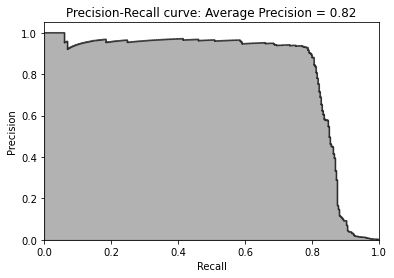

In [75]:
preds = pd.concat([y_train,predictionsBasedOnKFoldsEnsemble.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

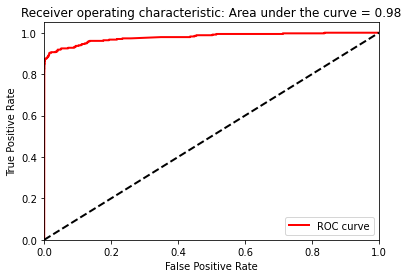

In [77]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: \
Area under the curve = {0:0.2f}'.format(areaUnderROC))
plt.legend(loc="lower right")
plt.show()

> 결과를 보면 모델 성능이 개선됐다고 볼 수 없습니다. 앙상블 모델의 로그 손실은 독립형 그레디언트 부스팅 모델의 로그 손실과 매우 유사합니다. 
가장 성능이 좋은 독립형 솔루션이 동일한 계열이기 때문에 결과가 개선되지 않았습니다. 
따라서 모델 다양화를 통한 이점은 없습니다.

### 13. 최종 모델 선택하기
- 앙상블을 시도해봤으나 성능이 개선되지 않았기 때문에 독립형 LightGBM을 사용할 겁니다. 
- 파이프라인을 만들기 전에 LightGBM 모델이 테스트 데이터셋에서 사기 거래와 정상 거래를 얼마나 잘 분류하는지 시각화하겠습니다.

,Predicted Probability,True Label
67353,0.000033,0
67626,0.000025,0
169699,0.005002,0
217315,0.000099,0
111420,0.000034,0


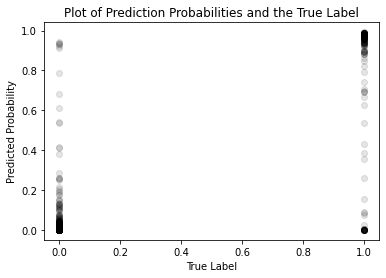

In [81]:
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
display(scatterData.head())

ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title( \
                'Plot of Prediction Probabilities and the True Label')

,True Label,Predicted Probability,value
0,0,Predicted Probability,0.000033
1,0,Predicted Probability,0.000025
2,0,Predicted Probability,0.005002
3,0,Predicted Probability,0.000099
4,0,Predicted Probability,0.000034


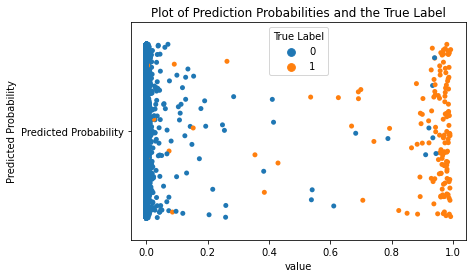

In [82]:
scatterDataMelted = pd.melt(scatterData, "True Label", var_name="Predicted Probability")
display(scatterDataMelted.head())

ax = sns.stripplot(x="value", y="Predicted Probability", hue='True Label', jitter=0.4, 
                   data=scatterDataMelted).set_title('Plot of Prediction Probabilities and the True Label')